# bunching estimation using the real data

take concept from simulation

In [29]:
# load packages
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
#import statsmodels.api as sm
import numpy as np
#from scipy.optimize import fsolve
#from scipy import integrate
from sympy import symbols, solve, Eq
import random
from heapq import nlargest
import tools # this imports the file tools.py // must be in the same folder as the current file
import zipfile

np.random.seed(111)

In [30]:
# load data
wd = Path.cwd()
folder = 'data/stata'
file = 'Outages_{period}.dta'
zip = 'Outages_{period}.zip'
zip = zipfile.ZipFile(wd.parent/folder/zip)
data = pd.read_stata(zip.open(file)) # convert_categoricals = True
#print(data.columns)


data['year'] = data.apply(lambda row: row.date.year, axis=1)

# keep year 2019
data = data[data.apply(lambda row: row.date.year == 2019, axis=1)]

# keep only unplanned
data = data.loc[data.planned != 'planned',]

# at least 100 custumers affected
data = data.loc[data.noofcustomersaffected >= 100] # comment it out for same results as in do-file

data.reset_index(drop = True)

# there is probably some rounding issue in unserveredmuduetooutage
# if it is 0 we replace it with 0.00001
data.loc[data.unservedmuduetooutage.isna() ,'unservedmuduetooutage'] = 0.00001


# keep one firm
#data = data.loc[data.discom == 'tata',]
#data.describe()

In [31]:
bunching = {}
for f in data.discom.unique():
    bunching[f] = {'data': data[data.discom == f]}

bunching['pooled'] = {'data': data} 

density of duration 

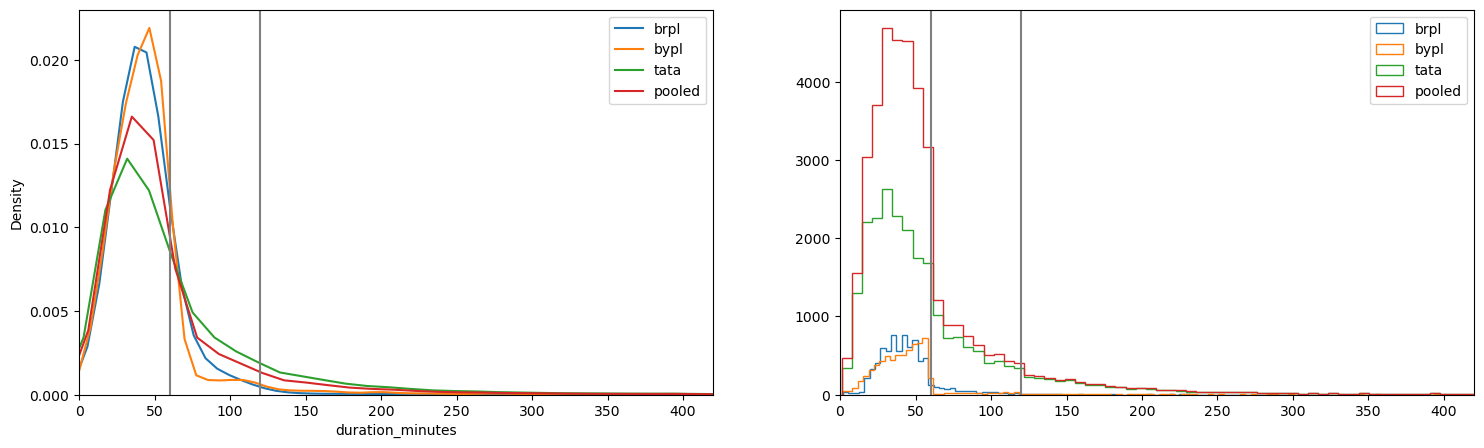

In [32]:
xmax  = 420

fig, axs = plt.subplots(1,2,figsize=(18,5))
for f in bunching:
    dt = bunching[f]['data']
    sns.kdeplot(dt.duration_minutes, ax = axs[0], label = f)
    axs[1].hist(dt.duration_minutes, histtype = 'step', bins = xmax, label = f)

axs[0].axvline(60, color  = 'grey')
axs[0].axvline(120, color  = 'grey')
axs[0].set_xlim(0,xmax)
axs[0].legend()

axs[1].axvline(60, color  = 'grey')
axs[1].axvline(120, color  = 'grey')
axs[1].set_xlim(0,xmax)
axs[1].legend()
plt.show()

# Bunching Estimation

- separately for each firm and notch
- define, binsize, excluded region, missing region, maximum  and minimum value of x considered and the degree of the poynomial (6 in the moment)
- preparation steps
    - create a dataframe at the bin-level by sorting all observations (duration) of the dataframe in bins with binsize as given
    - count the observations being in each bin
    - create polynomials of the lowerbound of each bin up the degree as given
    - create dummy variables for bunching and missing mass
- estimation
    - create a regressor matrix using an intercept, the polynomials and the dummy variables
    - OLS of #observations on the regressor matrix
- prediction
    - set all dummies to zero
    - use the estimated coefficients to predict the number of observations in each bin
- $\Delta x$ (total_bunch? - maybe be should switch our wording to avoid confusion)
    - extract the prediction and the actual observations in the excluded region 
    - using the estimated model parameters, approximate a function
    - integrate this function from the notch until notch + z 
    - get the difference between observation and prediction
    - from that difference, substract the calculated integral and find the value of z for which it is zero
    - the found z is our $\Delta x$

In [33]:
# bunching at x = 60
bsize = 1 # stata: 3
ex_reg = 10 # stata: 5
ex_reg_miss = 20 # stata: 5
z = 60
z_lower60 = z - bsize*ex_reg

missing60 = z + ex_reg_miss*bsize

for f in bunching:
    dt = bunching[f]['data']
    bunch60 = tools.bunching(dt.duration_minutes, bsize = bsize, xmax= 90, xmin= 0, z_upper= z, z_lower= z_lower60, missing = missing60, ex_reg= ex_reg, ex_reg_miss=ex_reg_miss, poly_dgr=6)
    bunching[f].update({'bunch60': bunch60})    
    #display(bunch60.estimation_res())
    print(f'-----bunching at 60 -----{f}----------')
    print('EX:', bunch60.get_deltaX(), 'mX:', bunch60.get_mX(), 'B:', bunch60.get_B())
    print('total bunching',bunch60.total_bunch())


#print(bunch60.df_count())


-----bunching at 60 -----brpl----------
EX: 1.1620387685390743 mX: -13.622800250493487 B: 141.47563910067538
total bunching 32.87928886626719
-----bunching at 60 -----bypl----------
EX: 4.407513769354879 mX: 38.91442471641811 B: 709.4227759653033


C:\Users\paula\anaconda3\envs\dehli\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


total bunching 28.3999077690923
-----bunching at 60 -----tata----------
EX: 2.418630215611267 mX: 0.7641043537804727 B: 644.6708796408611
total bunching 3.8512626419034377
-----bunching at 60 -----pooled----------
EX: 2.7246972509446223 mX: 0.014577523479048064 B: 1495.5692947066623
total bunching 40.34411641508353


In [34]:
#bunch60.estimation_res()

In [35]:
# bunching at x = 120
bsize = 1 # stata: 3
ex_reg = 10 # stata: 2
z = 120
z_lower120 = z - ex_reg * bsize
missing120 = z + ex_reg * bsize


for f in bunching:
    dt = bunching[f]['data']
    bunch120 = tools.bunching(dt.duration_minutes, bsize = bsize, xmax= 160, xmin= 90, z_upper= z, z_lower= z_lower120, missing = missing120, ex_reg= ex_reg, ex_reg_miss = ex_reg_miss, poly_dgr=6, include_missing=False)
    bunching[f].update({'bunch120': bunch120})
    #display(bunch120.estimation_res())
    print(f'-----bunching at 120 -----{f}----------')
    print('deltaX:', bunch120.get_deltaX())
    print('total bunching',bunch120.total_bunch())

#print(bunch120.df_count())


-----bunching at 120 -----brpl----------
deltaX: 5.26191126475232
total bunching 124.16632014960832
-----bunching at 120 -----bypl----------
deltaX: 3.7844824966707846


C:\Users\paula\anaconda3\envs\dehli\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


total bunching 103.52065059934577
-----bunching at 120 -----tata----------
deltaX: 2.416535726039766
total bunching 0.736274610773243
-----bunching at 120 -----pooled----------
deltaX: 2.740911651459331
total bunching 16.46686153636503


plot of counterfactual and actual data

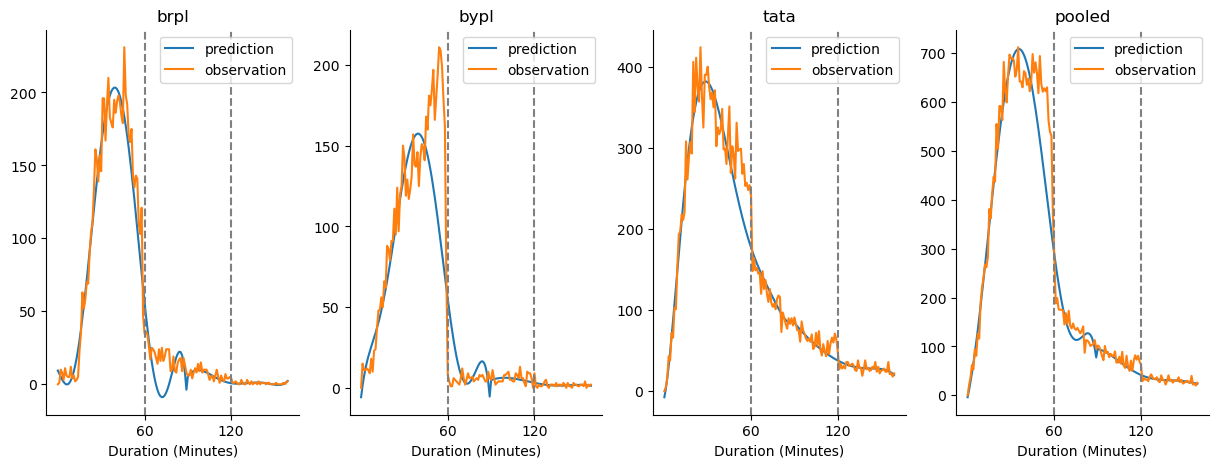

In [36]:
fig, ax = plt.subplots(1,len(bunching),figsize=(15,5))

for i in range(len(bunching)):
    f = list(bunching.keys())[i]
    # concat the two predictions
    pred60 = bunching[f]['bunch60'].prediction()
    pred120 = bunching[f]['bunch120'].prediction()
    pred = pd.concat([pred60,pred120], ignore_index=True)

    ax[i].plot(pred.duration, pred.y_pred, label = 'prediction')
    ax[i].plot(pred.duration, pred.nobs, label = 'observation')
    ax[i].axvline(60, color= 'grey', linestyle = 'dashed')
    ax[i].axvline(120, color= 'grey', linestyle = 'dashed')
    ax[i].set_xticks(ticks = [60, 120])
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_xlabel('Duration (Minutes)')
    ax[i].set_title(f)
    ax[i].legend()

plt.show()   

Visualize $\Delta x$

C:\Users\paula\anaconda3\envs\dehli\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


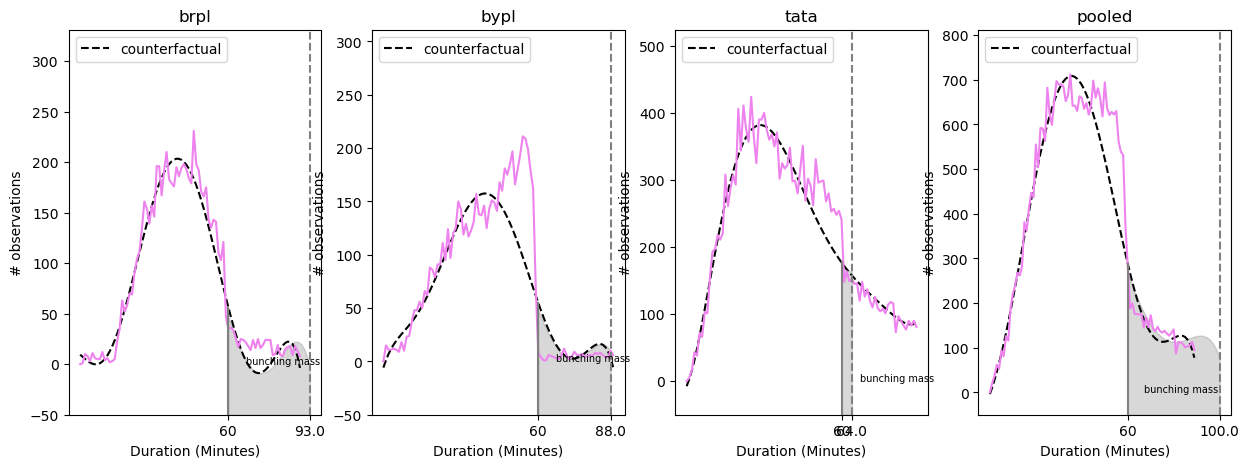

In [37]:
fig, ax = plt.subplots(1,len(bunching),figsize=(15,5))
min = -50
for i in range(len(bunching)):
    f = list(bunching.keys())[i]
    bunch = bunching[f]['bunch60']
    pred60 = bunching[f]['bunch60'].prediction()
    b = np.round(60 + bunch.total_bunch())
    ax[i].plot(pred60.duration[pred60.duration >= 0], pred60.y_pred[pred60.duration >= 0], color = 'black', linestyle='dashed', label = 'counterfactual')
    ax[i].plot(pred60.duration, pred60.nobs, color = 'violet')
    ax[i].plot([60,60], [min,pred60.loc[pred60.duration == 60, 'y_pred'].reset_index(drop=True)[0]], color = 'grey')
    ax[i].axvline(b,color='grey', linestyle = 'dashed')
    ax[i].set_xlabel('Duration (Minutes)')
    ax[i].set_ylabel('# observations')
    ax[i].set_xticks([60 , b])
    ax[i].set_xticklabels(labels = [60,b])
    ax[i].set_ylim(min,pred60.nobs.max()+ 100)
    ax[i].fill_between(np.linspace(60,b,np.sum((pred60.duration > 60) & (pred60.duration < b))),pred60.y_pred[(pred60.duration > 60) & (pred60.duration < b)], np.repeat(min,np.sum((pred60.duration > 60) & (pred60.duration < b))), alpha = .3, color = 'grey')
    ax[i].annotate('bunching mass', xy = (67,min + 50), size = 7)
    ax[i].legend()
    ax[i].set_title(f)
plt.show()
#fig.savefig('xdensity.png',dpi=120, format='png')

## get counterfactual duration at outage level

!! this is maybe not optimal. Right now, I am assuming a poisson distribution in the bins of the missing mass. \


- separately for each firm
- first, create a dataframe using the predictions from bunching estimation on bin-level
    - create dummies for bins being in the bunching and missing mass at 60 and 120
    - calculatie difference between number of observation in each bin and the prediction
    - calculate probability of an observation being in a specific bin: prediction/sum(prediction)
- second
    - for each bin in the bunching region
    - take difference in each bin, identify the observations (original data) that fall in that bin and randomly sample from those with size = difference
    - randomly select a bin from the missing mass weighted by the probability
    - redistribute observations from the selected bunching-bin to the selected missing-bin using a poisson distribution
- save this as column 'duration_cf' in the dataframe


In [41]:
for f in bunching:
    bunch60 = bunching[f]['bunch60']
    bunch120 = bunching[f]['bunch120']
    # concat the two predictions
    pred60 = bunch60.prediction()
    pred120 = bunch120.prediction()
    pred60 = pred60[pred60.duration <= 100]
    pred120 = pred120[pred120.duration > 100]
    cf = pd.concat([pred60,pred120], ignore_index=True)
    # first need to get the counterfactuals for the bins    
    cf = cf.loc[:,['bin', 'nobs', 'duration', 'b', 'm','y_pred']]
    cf['difference'] = cf.nobs - cf.y_pred
    # make sure that at least one bin is in missing
    upper60 = 60 + abs(bunch60.total_bunch()) + bsize 
    upper120 = 120 + abs(bunch120.total_bunch()) + bsize 
    # create dummies
    cf['b60'] = cf.apply(lambda row: 1 if (row.b ==1) & (row.duration <= missing60) else 0, axis = 1)
    cf['missing60'] = cf.apply(lambda row: 1 if (row.duration > 60) & (row.duration <= upper60) else 0, axis = 1)
    cf['b120'] = cf.apply(lambda row: 1 if (row.b ==1) & (row.duration >= z_lower120) else 0, axis = 1)
    cf['missing120'] = cf.apply(lambda row: 1 if (row.duration > 120) & (row.duration <= upper120) else 0, axis = 1)

    # calculate missing
    sum60 = cf.loc[(cf.duration > 60) & (cf.duration <= upper60) & (cf.y_pred >= 0),'y_pred'].sum()
    sum120 = cf.loc[(cf.duration > 120) & (cf.duration <= upper120) & (cf.y_pred >= 0),'y_pred'].sum()

    # calculate probability of being in bin, avoiding negative probabilities
    cf['prob'] = 0
    cf.loc[(cf.duration > 60) & (cf.duration <= upper60) & (cf.y_pred >= 0), 'prob'] = cf.y_pred / sum60
    cf.loc[(cf.duration > 120) & (cf.duration <= upper120) & (cf.y_pred >= 0), 'prob'] = cf.y_pred / sum120

    print(cf.prob.sum() == 2)
    #print(cf[(cf.b60 == 1) | (cf.b120 == 1) | (cf.missing120 == 1) | (cf.missing60 == 1)])

    # save in dictionary
    bunching[f].update({'counterfactual_bins':cf})

True


C:\Users\paula\anaconda3\envs\dehli\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\paula\anaconda3\envs\dehli\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


True
True
True


In [44]:
cf[40:70]

,bin,nobs,duration,b,m,y_pred,difference,b60,missing60,b120,missing120,prob
40,"(40, 41)",659,40,0,0,688.280297,-29.280297,0,0,0,0,0.000000
41,"(41, 42)",635,41,0,0,678.519567,-43.519567,0,0,0,0,0.000000
42,"(42, 43)",648,42,0,0,666.977132,-18.977132,0,0,0,0,0.000000
43,"(43, 44)",622,43,0,0,653.734471,-31.734471,0,0,0,0,0.000000
44,"(44, 45)",641,44,0,0,638.883470,2.116530,0,0,0,0,0.000000
45,"(45, 46)",698,45,0,0,622.525949,75.474051,0,0,0,0,0.000000
46,"(46, 47)",660,46,0,0,604.773125,55.226875,0,0,0,0,0.000000
47,"(47, 48)",681,47,0,0,585.745018,95.254982,0,0,0,0,0.000000
48,"(48, 49)",659,48,0,0,565.569794,93.430206,0,0,0,0,0.000000
49,"(49, 50)",618,49,0,0,544.383052,73.616948,0,0,0,0,0.000000


In [45]:
## difference in b60 need to be distributed to missing mass

# new column
data['duration_cf'] = data.duration_minutes

# in case of pooling etc.
notfirms = [x for x in bunching.keys() if x not in data.discom.unique()]
for x in notfirms:
    data[f'duration_cf_{f}'] = data.duration_minutes


for f in bunching:
    # subset dataframe but keep index
    if f in data.discom.unique():
        dt = data[data.discom == f]
        column = 'duration_cf'
    if f not in data.discom.unique():
        dt = data.copy()
        column = f'duration_cf_{f}'
    
    
    # get counterfactual bins
    cf = bunching[f]['counterfactual_bins']

    dict = {'60': cf.loc[(cf.b60 ==1) & (cf.difference >0),].index, '120': cf.loc[(cf.b120 ==1) & (cf.difference >0),].index}
    dict_m = {'60': cf.missing60, '120':cf.missing120}

    for d in ['60','120']:
        ind = dict[d]
        m = dict_m[d]
        for b in ind:
            # select bin
            bin = cf.bin[b]   
            # get 'extra' observations
            diff = np.round(cf.difference[b]).astype(int)
            #print(bin, diff)
            # extract the data in bin and select n = diff random values
            new_data = dt.loc[(dt.duration_cf >= bin[0]) & (dt.duration_cf <= bin[1])].sample(n = diff, axis = 0, replace=True)
            # now randomly choose a bin in the missing mass, weighted by prob of observations being in that bin bin
            mis = cf.loc[m == 1,].sample(n=1, axis =0, weights = cf.prob).bin.reset_index(drop=True)[0]
            # create n=diff random values in bin
            new = np.random.poisson((mis[1] +  mis[0])/2, size = diff) # here I am assuming a poisson distribution in the bins
            # replace values in 
            data.loc[new_data.index.tolist(), column] = new
            dt.loc[new_data.index.tolist(), column] = new           

#data.describe()

C:\Users\paula\anaconda3\envs\dehli\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


### plot of estimated counterfactual distribution and actual distribution

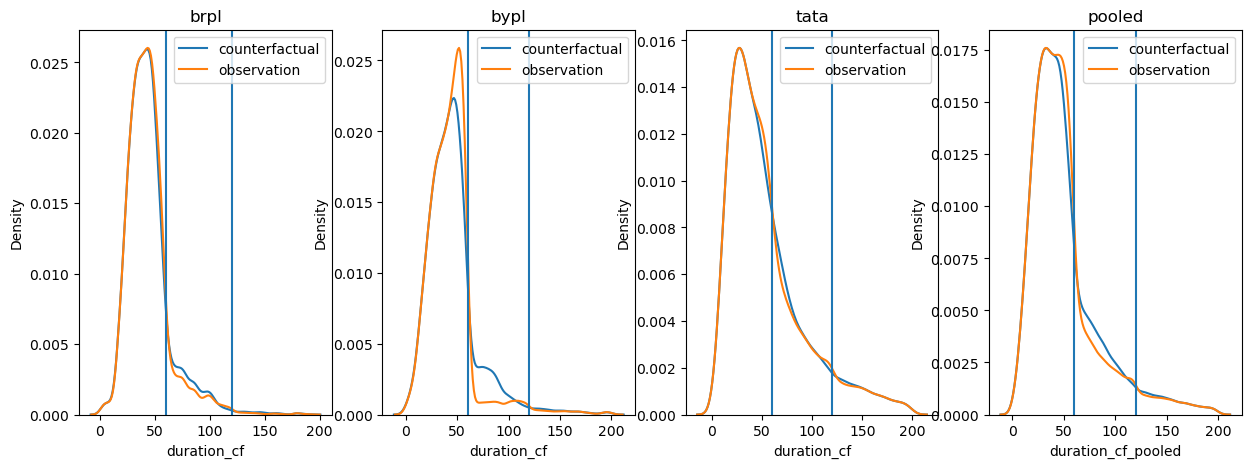

In [46]:
# should look similar to counterfactual density from bunching estimation
fig, ax = plt.subplots(1,len(bunching),figsize=(15,5))
for i in range(len(bunching)):
    f = list(bunching.keys())[i]
    column = 'duration_cf'
    dt = data[data.discom == f]
    if f not in data.discom.unique(): 
        column = f'duration_cf_{f}'
        dt = data
    sns.kdeplot(dt[column][dt[column] < 200], label = 'counterfactual', ax = ax[i])
    sns.kdeplot(dt.duration_minutes[dt.duration_minutes < 200], label='observation', ax = ax[i])
    ax[i].axvline(60)
    ax[i].axvline(120)
    ax[i].legend()
    ax[i].set_title(f)
plt.show()
#plt.xlim(55,65)
#plt.ylim(0.000,0.004)


In [47]:
# export 
data.to_csv(wd.parent/'data'/'data_transformed'/'outage_bunch.csv', index=False)